In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from operator import attrgetter
import missingno as msno
import matplotlib.colors as mcolors
from textwrap import wrap

In [2]:
df=pd.read_csv('E:/DS/Data Set 2/Data Set 2.csv', parse_dates=['created_on'],index_col='created_on')
df1=pd.read_csv('E:/DS/Data Set 2/Data Set 2.csv', parse_dates=['created_on'])

In [3]:
df

,id,customer_id,location_id,channel,amount,bill_no
created_on,,,,,,
2018-06-24 00:00:00,42877344,60,192,uber,1039,GGN001-24323
2018-01-14 19:21:00,35625005,134,535,takeaway,1029,DEL007-1522
2018-09-13 13:40:00,44397299,166,347,uber,355,DEL005-29173
2018-09-13 14:33:00,44405460,166,347,uber,371,DEL005-29180
2018-09-16 12:40:00,44717004,166,347,uber,371,DEL005-29603
...,...,...,...,...,...,...
2019-10-04 14:21:00,63920571,11655184,218,zomato,674,GGN004-49266
2019-10-04 10:11:00,63920575,11655185,4002,dine in,1565,DEL009-26660
2019-10-04 15:44:00,63920583,11655186,194,zomato,217,GGN002-70779


In [4]:
df.isnull().sum()

id             0
customer_id    0
location_id    0
channel        0
amount         0
bill_no        0
dtype: int64

In [5]:
def get_month(x): return dt.datetime(1, x.month, x.year)

# Time Series Analysis

<AxesSubplot:xlabel='created_on'>

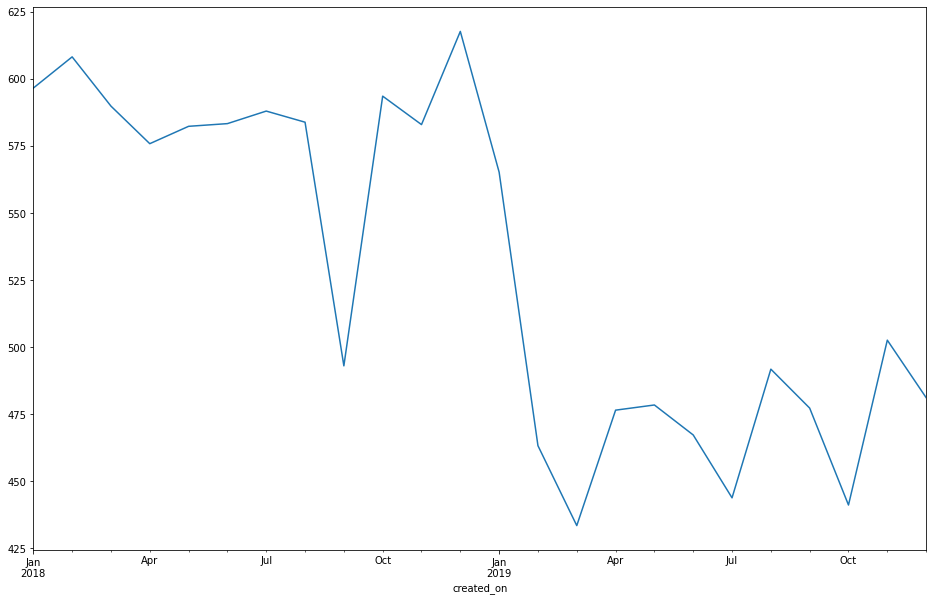

In [6]:
#monthly frequency
%matplotlib inline
plt.figure(figsize=(16, 10))
df.amount.resample('M').mean().plot()

<AxesSubplot:xlabel='created_on'>

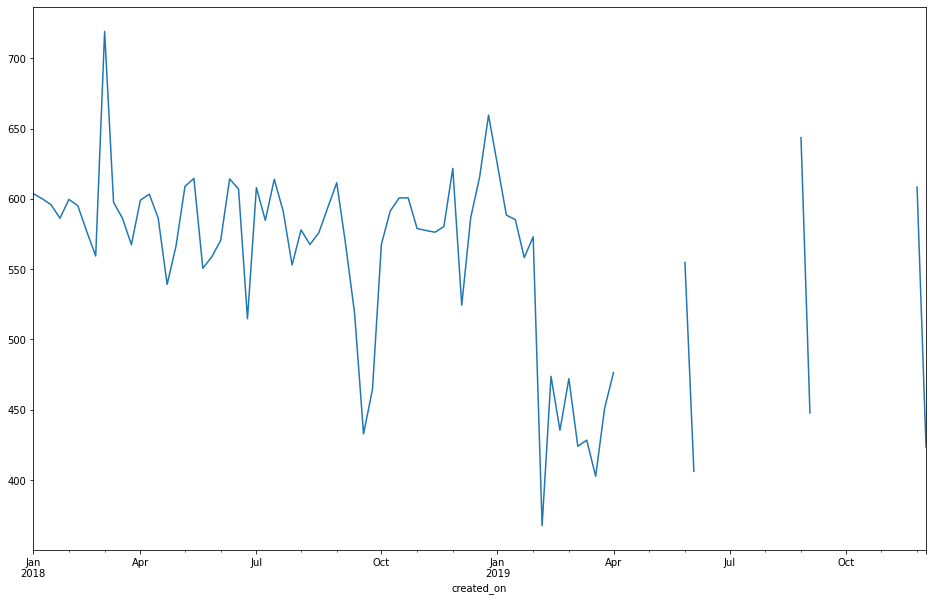

In [7]:
#Weekly frequency
%matplotlib inline
plt.figure(figsize=(16, 10))
df.amount.resample('W').mean().plot()

<AxesSubplot:xlabel='created_on'>

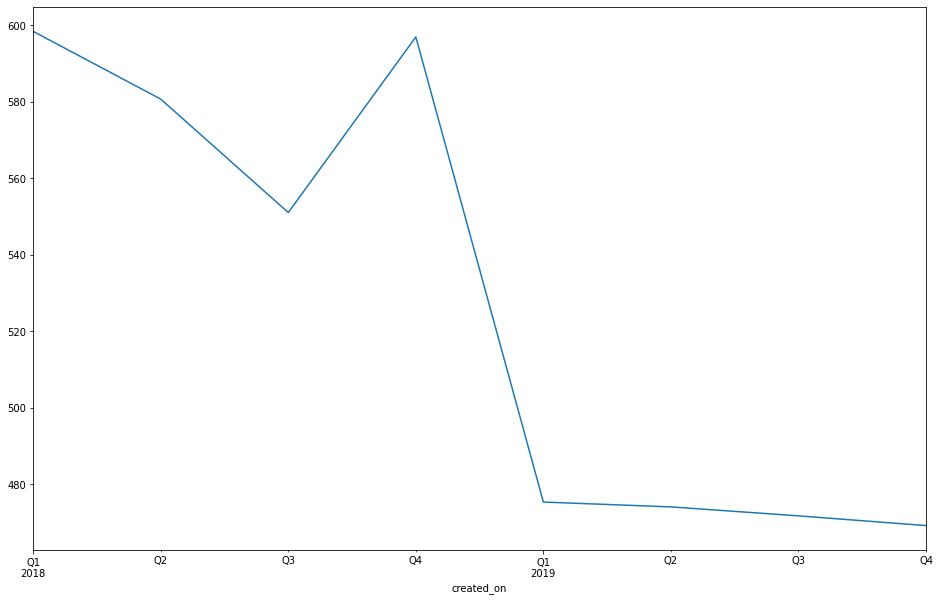

In [8]:
#Quaterly frequency
%matplotlib inline
plt.figure(figsize=(16, 10))
df.amount.resample('Q').mean().plot()

<AxesSubplot:xlabel='created_on'>

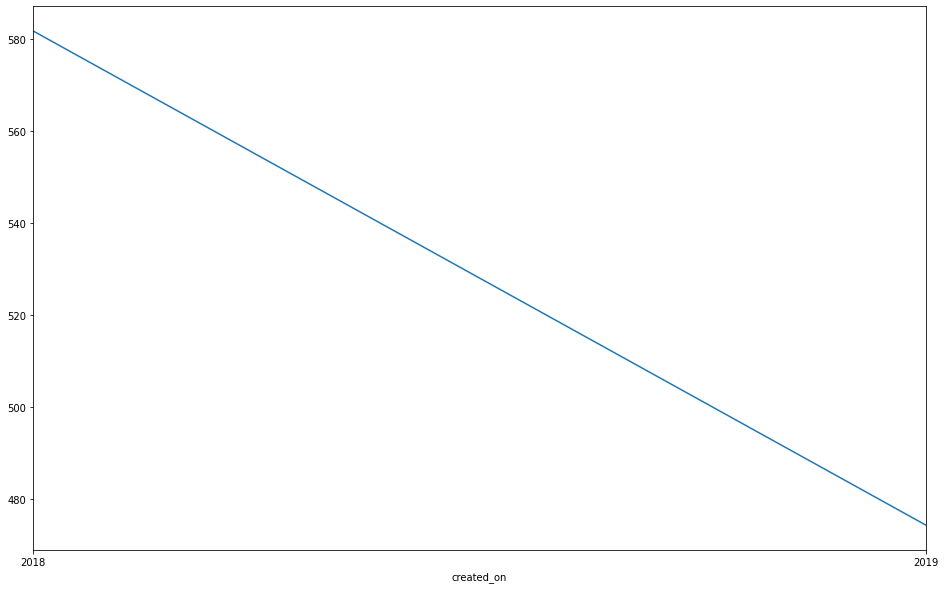

In [9]:
#Yearly frequency
%matplotlib inline
plt.figure(figsize=(16, 10))
df.amount.resample('Y').mean().plot()

<AxesSubplot:xlabel='created_on'>

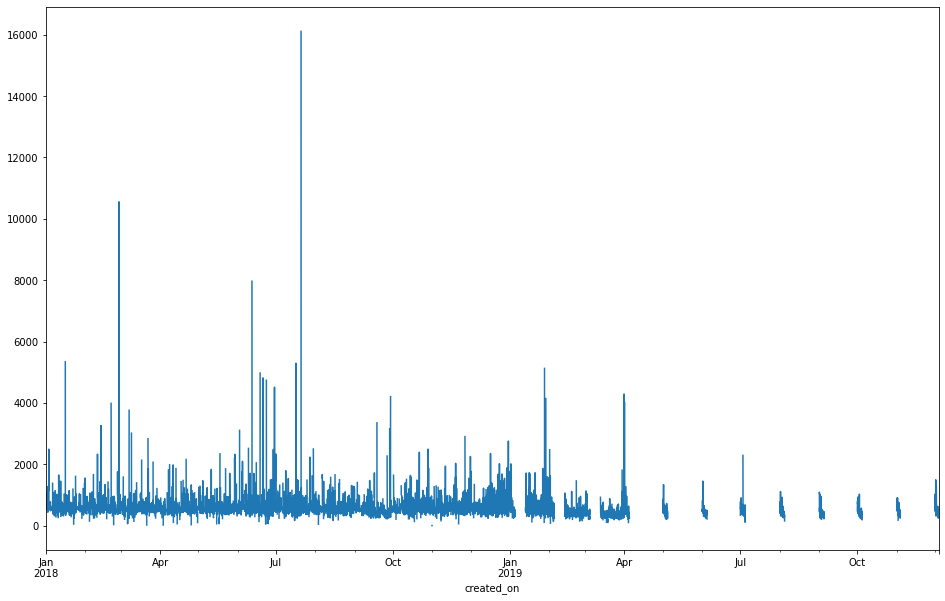

In [10]:
#Hourly frequency
%matplotlib inline
plt.figure(figsize=(16, 10))
df.amount.resample('H').mean().plot()

<AxesSubplot:xlabel='created_on'>

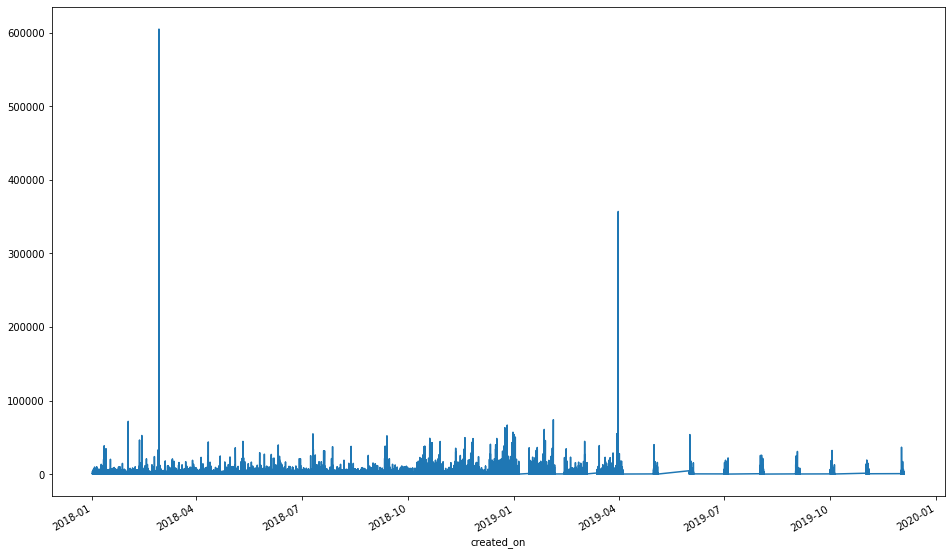

In [11]:
plt.figure(figsize=(16, 10))
df.amount.plot()

In [12]:
df['amount'].describe().transpose()

count    533327.000000
mean        551.399865
std        1388.179206
min           0.000000
25%         304.000000
50%         372.000000
75%         584.000000
max      604827.000000
Name: amount, dtype: float64

In [13]:
n_orders = df.groupby(['customer_id'])['bill_no'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

35.83% of customers ordered more than once.


C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


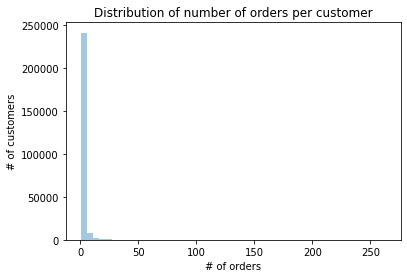

In [14]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

# Cohort Analysis

In [15]:
df1['order_month'] = df1['created_on'].dt.to_period('M')
df1['cohort'] = df1.groupby('customer_id')['created_on'] \
                 .transform('min') \
                 .dt.to_period('M')

In [16]:
df_cohort = df1.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [17]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [18]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [19]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

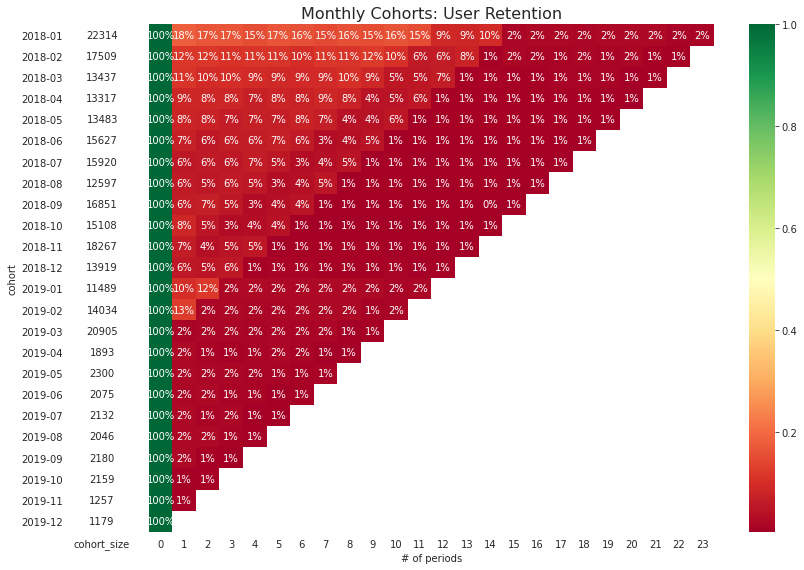

In [20]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()